Reading logs from ../logs/V1
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found


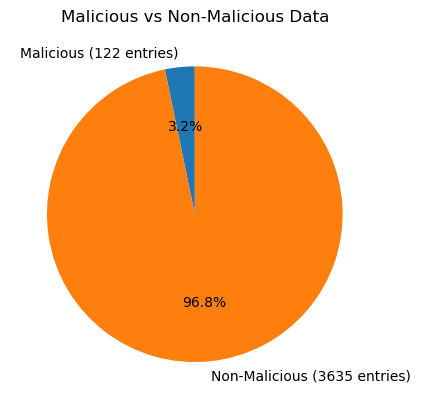

In [8]:
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
import matplotlib.pyplot as plt

df = read_all_logs(version=1)
df = Preprocessor.get(version=1).preprocess(df)

# Count the number of malicious and non-malicious entries
malicious_count = df['malicious'].sum()
non_malicious_count = len(df) - malicious_count

# Create labels and sizes for the pie chart
labels = [f'Malicious ({malicious_count} entries)', f'Non-Malicious ({non_malicious_count} entries)']
sizes = [malicious_count, non_malicious_count]

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Malicious vs Non-Malicious Data')

# Display the chart
plt.show()


Best model: 
Model               NB
Scaler       Frequency
Min Ngram            1
Max Ngram            1
Score              1.0
Name: 0, dtype: object


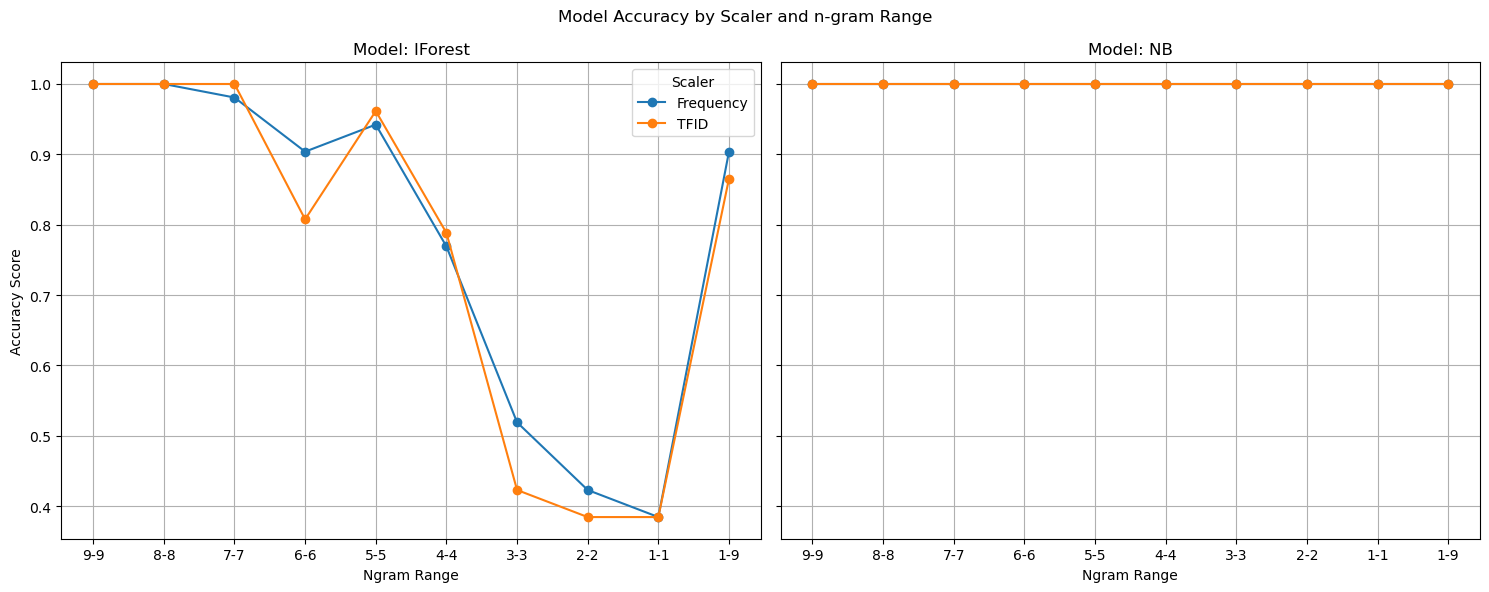

In [9]:
# V1 models evaluation results
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=1, output_dir=models_dir)

# Create graph of accuracy per model
print("Best model: ")
print(model_score.iloc[0])

model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

# Create a figure with subplots for each model
models = model_score['Model'].unique()
models.sort()
fig, axs = plt.subplots(1, len(models), figsize=(15, 6), sharey=True) 

for ax, model in zip(axs, models):
    df_model = model_score[model_score['Model'] == model]
    for label, df_grouped in df_model.groupby('Scaler'):
        ax.plot(df_grouped['Min Ngram'].astype(str) + "-" + df_grouped['Max Ngram'].astype(str), 
                df_grouped['Score'], label=label, marker='o')
    ax.set_title(f'Model: {model}')
    ax.set_xlabel('Ngram Range')
    if ax == axs[0]:
        ax.set_ylabel('Accuracy Score')
        ax.legend(title='Scaler')
    ax.grid(True)

plt.suptitle('Model Accuracy by Scaler and n-gram Range')

plt.tight_layout()
plt.show()


Reading logs from ../logs/V1
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found


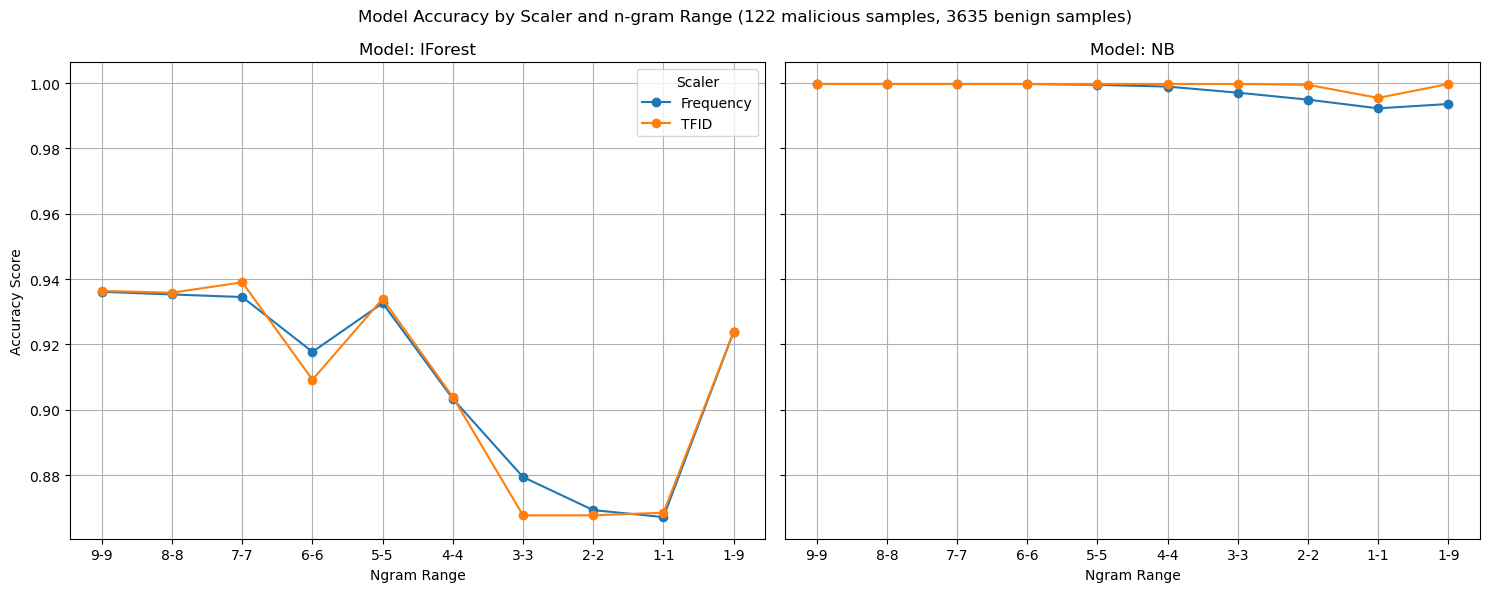

,Model,Score,Scaler,Min Ngram,Max Ngram
10,NB,0.999734,Frequency,9,9
11,NB,0.999734,Frequency,7,7
38,NB,0.999734,TFID,3,3
5,NB,0.999734,TFID,1,9
27,NB,0.999734,TFID,4,4
37,NB,0.999734,TFID,5,5
4,NB,0.999734,Frequency,6,6
36,NB,0.999734,TFID,7,7
26,NB,0.999734,TFID,6,6
8,NB,0.999734,Frequency,8,8


In [10]:
#V1 accuracy accross entire dataset
from train_models import load_model
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained/v1')
model_files = [os.path.join(models_dir, file) for file in os.listdir(models_dir) if file.endswith('.pkl')]
models = [load_model(model_file) for model_file in model_files]

# Load data
df = read_all_logs(version=1)
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

nr_mal_samples = df['malicious'].sum()
nr_benign_samples = len(df) - nr_mal_samples

# Evaluate models
model_score = []
for model in models:
    score = model.get_score(df['syscall'], df['malicious'])
    model_score.append({'Model': model.get_model_type(), 'Score': score, 'Scaler': model.get_scaler_type(), 'Min Ngram': model.get_ngram_range()[0], 'Max Ngram': model.get_ngram_range()[1]})

# Create graph of accuracy per model
model_score = pd.DataFrame(model_score)
model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

models = model_score['Model'].unique()
models.sort()
fig, axs = plt.subplots(1, len(models), figsize=(15, 6), sharey=True) 

for ax, model in zip(axs, models):
    df_model = model_score[model_score['Model'] == model]
    for label, df_grouped in df_model.groupby('Scaler'):
        ax.plot(df_grouped['Min Ngram'].astype(str) + "-" + df_grouped['Max Ngram'].astype(str), 
                df_grouped['Score'], label=label, marker='o')
    ax.set_title(f'Model: {model}')
    ax.set_xlabel('Ngram Range')
    if ax == axs[0]:
        ax.set_ylabel('Accuracy Score')
        ax.legend(title='Scaler')
    ax.grid(True)

plt.suptitle(f'Model Accuracy by Scaler and n-gram Range ({nr_mal_samples} malicious samples, {nr_benign_samples} benign samples)')

plt.tight_layout()
plt.show()

model_score.sort_values('Score', ascending=False)


Reading logs from ../logs/V1
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found


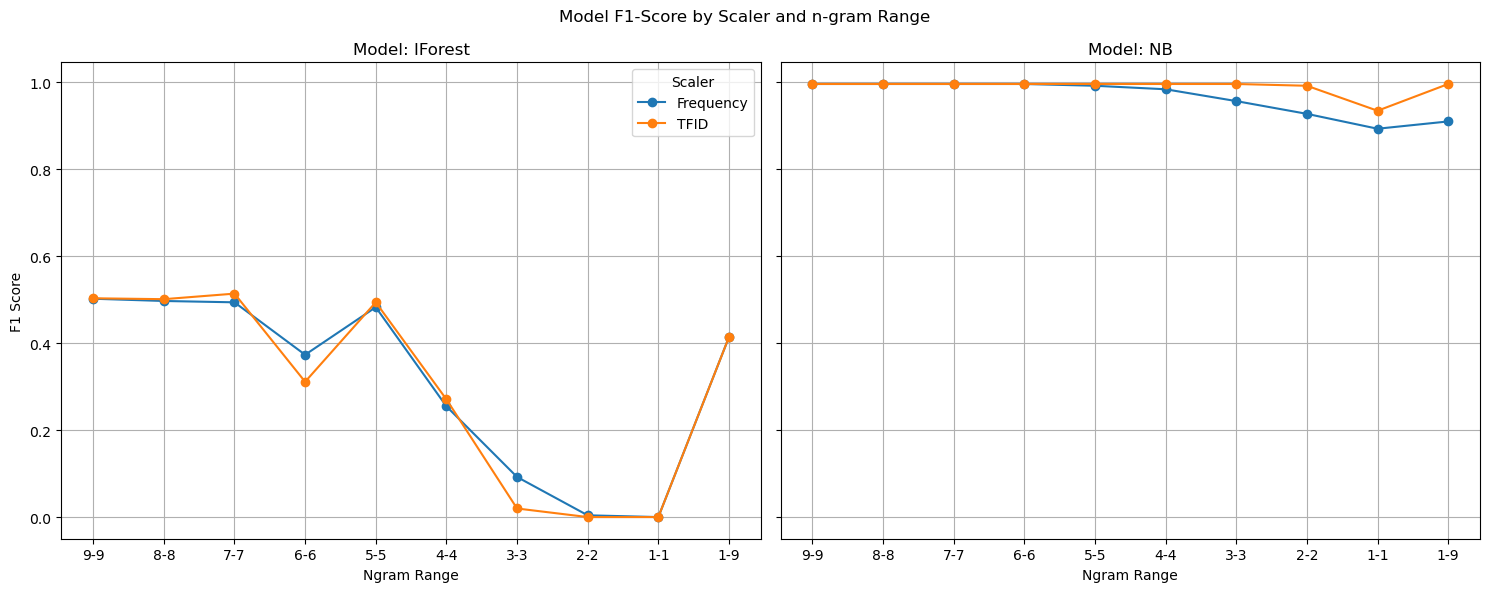

,Model,Score,Scaler,Min Ngram,Max Ngram
10,NB,0.995885,Frequency,9,9
11,NB,0.995885,Frequency,7,7
38,NB,0.995885,TFID,3,3
5,NB,0.995885,TFID,1,9
27,NB,0.995885,TFID,4,4
37,NB,0.995885,TFID,5,5
4,NB,0.995885,Frequency,6,6
36,NB,0.995885,TFID,7,7
26,NB,0.995885,TFID,6,6
8,NB,0.995885,Frequency,8,8


In [11]:
#V1 F1 score accross entire dataset
from train_models import load_model
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import f1_score

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained/v1')
model_files = [os.path.join(models_dir, file) for file in os.listdir(models_dir) if file.endswith('.pkl')]
models = [load_model(model_file) for model_file in model_files]

# Load data
df = read_all_logs(version=1)
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

# Evaluate models
model_score = []
for model in models:
    y_pred = model.predict(df['syscall'])
    score = f1_score(df['malicious'], y_pred)
    model_score.append({'Model': model.get_model_type(), 'Score': score, 'Scaler': model.get_scaler_type(), 'Min Ngram': model.get_ngram_range()[0], 'Max Ngram': model.get_ngram_range()[1]})

# Create graph of accuracy per model
model_score = pd.DataFrame(model_score)
model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

models = model_score['Model'].unique()
models.sort()
fig, axs = plt.subplots(1, len(models), figsize=(15, 6), sharey=True) 

for ax, model in zip(axs, models):
    df_model = model_score[model_score['Model'] == model]
    for label, df_grouped in df_model.groupby('Scaler'):
        ax.plot(df_grouped['Min Ngram'].astype(str) + "-" + df_grouped['Max Ngram'].astype(str), 
                df_grouped['Score'], label=label, marker='o')
    ax.set_title(f'Model: {model}')
    ax.set_xlabel('Ngram Range')
    if ax == axs[0]:
        ax.set_ylabel('F1 Score')
        ax.legend(title='Scaler')
    ax.grid(True)

plt.suptitle('Model F1-Score by Scaler and n-gram Range')

plt.tight_layout()
plt.show()
model_score.sort_values('Score', ascending=False)


Reading logs from ../logs/V1
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found


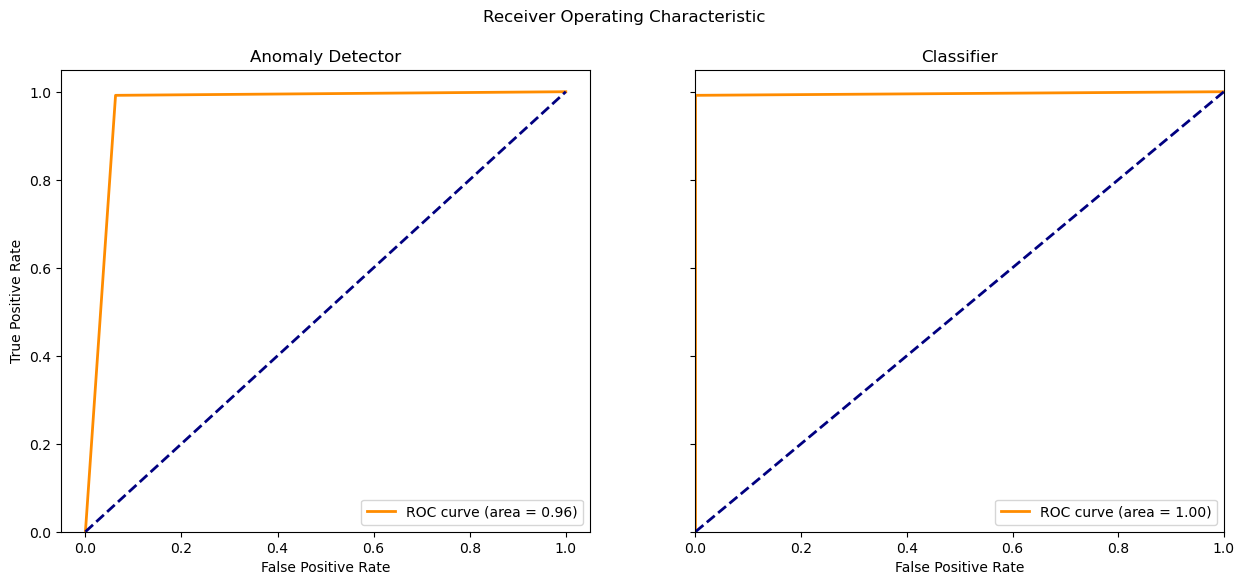

In [15]:
# V1 ROC curve of best classifier and best anomaly detector
from train_models import load_model
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Load models
classifier = load_model('models/trained/v1/v1_NB_TFID_9_9.pkl')
anomaly_detector = load_model('models/trained/v1/v1_IForest_TFID_7_7.pkl')

# Load data
df = read_all_logs(version=1)
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

# Evaluate models
y_true = df['malicious']
y_score_anomaly_detector = anomaly_detector.predict(df['syscall'])
y_score_classifier = classifier.predict(df['syscall'])

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True) 

# anomaly detector
axs[0].set_title('Anomaly Detector')
fpr, tpr, thresholds = roc_curve(y_true, y_score_anomaly_detector)
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].legend(loc="lower right")
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

# classifier
axs[1].set_title('Classifier')
fpr, tpr, thresholds = roc_curve(y_true, y_score_classifier)
roc_auc = auc(fpr, tpr)
axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[1].legend(loc="lower right")
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlabel('False Positive Rate')

plt.suptitle('Receiver Operating Characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()



In [13]:
#V1 IForest vs NB difference in predictions
from train_models import load_model
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Load models
classifier = load_model('models/trained/v1/v1_NB_TFID_7_7.pkl')
anomaly_detector = load_model('models/trained/v1/v1_IForest_TFID_7_7.pkl')

# Load data
df = read_all_logs(version=1)
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

df['pred_anomaly'] = anomaly_detector.predict(df['syscall'])
df['pred_classifier'] = classifier.predict(df['syscall'])

df['diff_anomaly'] = df['pred_anomaly'] - df['malicious']
df['diff_classifier'] = df['pred_classifier'] - df['malicious']

print("F1, anomaly detector: ", f1_score(df['malicious'], df['pred_anomaly']))
print("F1, classifier: ", f1_score(df['malicious'], df['pred_classifier']))

df['diff_anomaly'].value_counts()

Reading logs from ../logs/V1
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found
F1, anomaly detector:  0.51380042462845
F1, classifier:  0.9958847736625513


diff_anomaly
 0    3528
 1     228
-1       1
Name: count, dtype: int64

Classifying malicious_ransim-slow_10min.log as malicious, 106 malicious entries found
Classifying malicious_ransim_5min.log as malicious, 478 malicious entries found


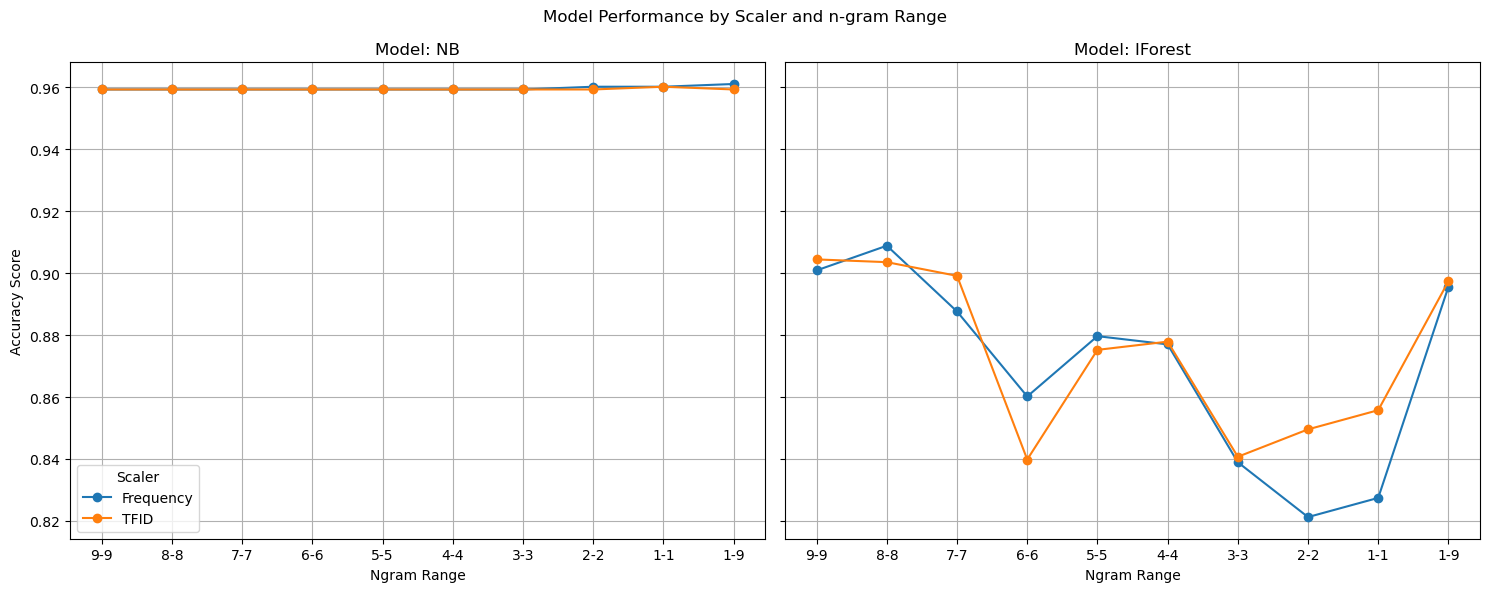

In [14]:
#V1 accross v2 dataset
from train_models import load_model
from log_reader import read_logs_from_dir
from preprocessors.preprocessor import Preprocessor
import matplotlib.pyplot as plt
import os
import pandas as pd

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained/v1')
model_files = [os.path.join(models_dir, file) for file in os.listdir(models_dir) if file.endswith('.pkl')]
models = [load_model(model_file) for model_file in model_files]

# Load data
df = read_logs_from_dir('../logs/V2')
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

# Evaluate models
model_score = []
for model in models:
    score = model.get_score(df['syscall'], df['malicious'])
    model_score.append({'Model': model.get_model_type(), 'Score': score, 'Scaler': model.get_scaler_type(), 'Min Ngram': model.get_ngram_range()[0], 'Max Ngram': model.get_ngram_range()[1]})

# Create graph of accuracy per model
model_score = pd.DataFrame(model_score)
model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

models = model_score['Model'].unique()
fig, axs = plt.subplots(1, len(models), figsize=(15, 6), sharey=True) 

for ax, model in zip(axs, models):
    df_model = model_score[model_score['Model'] == model]
    for label, df_grouped in df_model.groupby('Scaler'):
        ax.plot(df_grouped['Min Ngram'].astype(str) + "-" + df_grouped['Max Ngram'].astype(str), 
                df_grouped['Score'], label=label, marker='o')
    ax.set_title(f'Model: {model}')
    ax.set_xlabel('Ngram Range')
    if ax == axs[0]:
        ax.set_ylabel('Accuracy Score')
        ax.legend(title='Scaler')
    ax.grid(True)

plt.suptitle('Model Performance by Scaler and n-gram Range')

plt.tight_layout()
plt.show()
